In [1]:
import pandas as pd
import NanobodyPaperPlotting
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#"globals"
lowBDFPCutoff = 0.75
highBDFPCutoff = 1

colors_decimal = [[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]]

#set plotting limits
#NanobodyPaperPlotting uses 10**n values, but sns.kdeplot uses n values
expressionLims = (10**0.25, 10**3)
BDFPPositiveBDFPSSCLims = (10**-1, 10**3)
BDFPNegativeBDFPSSCLims = (10**-4, 10**1)

expressionLims_kde = (0.25, 3)
BDFPPositiveBDFPSSCLims_kde = (-1, 3)
BDFPNegativeBDFPSSCLims_kde = (-4, 1)

mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
BDFPExpressionLabel = "BDFP concentration (p.d.u.)"

In [3]:
#file helpers
def dataToPlotFromFilelist(files, title):
    """
    handles the single title filelist portion of titledFiles (parameter for DAmFRETRow_files)
    files should be a 1d list of files in population label order
    """
    data = pd.DataFrame()
    for i, file in enumerate(files):
        # populationData = DAmFRETClusteringTools.readDataToDF(file, minAmFRET=-10, maxAmFRET=10, minAmFRETPercentile=0, maxAmFRETPercentile=100, minAcceptorPercentile=0, maxAcceptorPercentile=100, xAxis="log(Acceptor/SSC)")
        populationData = NanobodyPaperPlotting.readDataToDF(file, minAmFRET=-10, maxAmFRET=10, minAmFRETPercentile=0, maxAmFRETPercentile=100, minAcceptorPercentile=0, maxAcceptorPercentile=100, xAxis="log(Acceptor/SSC)")
        populationData["label"] = i
        data = pd.concat([data, populationData])
        
    #These values were decided early on and they should not be function parameters!
    lowBDFPCutoff = 0.75
    highBDFPCutoff = 1
    
    dataLowBDFP = data[data["BDFP1.6-A"] <= (10 ** lowBDFPCutoff)]
    dataHighBDFP = data[data["BDFP1.6-A"] >= (10 ** highBDFPCutoff)]

    if title.lower() == "control" or title.lower() == "x3912b":
        return (dataLowBDFP, "bdfp-")
    else:
        return (dataHighBDFP, "BDFP+")

def DAmFRETRow_files(titledFiles, axs):
    """
    titledFiles should contain a list of tuples that contain a title and a list of files:
    [(<title>, [<filename for population 0>, <filename for population 1>, ...]), ...]
    """
    for i, (title, files) in enumerate(titledFiles):
        dataToPlot, _ = dataToPlotFromFilelist(files, title)
        
        mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
        NanobodyPaperPlotting.plotDAmFRETDensity(dataToPlot["Acceptor/SSC"], dataToPlot["AmFRET"], xlab=mEosExpressionLabel, logX=True, ax=axs[i], xlims=expressionLims, title=title)

def populationRow_files(titledFiles, axs, expressionRange=None, colors=[[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]]):
    """
    titledFiles should contain a list of tuples that contain a title and a list of files:
    [(<title>, [<filename for population 0>, <filename for population 1>, ...]), ...]
    expressionRange can take a tuple of values between which population size and proportion will be reported on the plots
    """
    for i, (title, files) in enumerate(titledFiles):
        dataToPlot, _ = dataToPlotFromFilelist(files, title)

        mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
        NanobodyPaperPlotting.plotDAmFRETClusters(dataToPlot["Acceptor/SSC"], dataToPlot["AmFRET"], dataToPlot["label"], xlab=mEosExpressionLabel, logX=True, ax=axs[i], xlims=expressionLims, title=title, colors=colors)

        #handle expressionRange
        if expressionRange is not None:
            axs[i].vlines(expressionRange, -0.2, 2, color="red", linestyles="-.")
            dataWithinBin = dataToPlot[(dataToPlot["Acceptor/SSC"] >= expressionRange[0]) & (dataToPlot["Acceptor/SSC"] <= expressionRange[1])]
            labels, labelCounts = np.unique(dataWithinBin["label"], return_counts=True)
        else:
            # labels, labelCounts = np.unique(dataToPlot["label"], return_counts=True)
            continue #NanobodyPaaperPlotting.plotDAmFRETClusters has been updated to have good default posiitoning
            
        labelCountDict = dict(zip(labels, labelCounts))
        
        #remove default text
        for text in axs[i].texts:
            text.set_visible(False)
        
        #add better text
        textX = 0.01
        textYMax = 0.98
        #make the label for the highest pop
        label = labels.max()
        higherText = axs[i].text(textX, textYMax, f"{labelCountDict[label]}, {labelCountDict[label] / sum(labelCountDict.values()):.2f}", va="top", ha="left", color=colors[label], transform = axs[i].transAxes)
        
        #make label for non-highest pop(s)
        for label in labels[-2::-1]:
            higherText = axs[i].annotate(f"{labelCountDict[label]}, {labelCountDict[label] / sum(labelCountDict.values()):.2f}", xycoords=higherText, xy=(0,-1), color=colors[label], horizontalalignment="left", transform = axs[i].transAxes)

def contourRow_files(titledFiles, axs, labels=None, colors=[[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]], labelColumn="label", hueOrder=None):
    """
    titledFiles should contain a list of tuples that contain a title and a list of files:
    [(<title>, [<filename for population 0>, <filename for population 1>, ...]), ...]
    expressionRange can take a tuple of values between which population size and proportion will be reported on the plots
    """
    # print("SKIPPING DURING TESTING")
    # return
    
    for i, (title, files) in enumerate(titledFiles):
        dataToPlot, BDFPExpressionGroup = dataToPlotFromFilelist(files, title)

        expressionLims = (10**0.25, 10**3)
        BDFPPositiveBDFPSSCLims = (10**-1, 10**3)
        BDFPNegativeBDFPSSCLims = (10**-4, 10**1)
        
        expressionLims_kde = (0.25, 3)
        BDFPPositiveBDFPSSCLims_kde = (-1, 3)
        BDFPNegativeBDFPSSCLims_kde = (-4, 1)
        
        if BDFPExpressionGroup == "BDFP+":
            ylims = BDFPPositiveBDFPSSCLims_kde
        else:
            ylims = BDFPNegativeBDFPSSCLims_kde

        #labels hasn't ben hanlded yet
        if labels is None:
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(dataToPlot, labelColumn=labelColumn, ax=axs[i], colors=colors, ylims=ylims, xlims=expressionLims_kde, hueOrder=hueOrder)
        else:
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(dataToPlot[dataToPlot[labelColumn].isin(labels)], labelColumn=labelColumn, ax=axs[i], colors=colors, ylims=ylims, xlims=expressionLims_kde, hueOrder=hueOrder)

        mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
        BDFPExpressionLabel = "BDFP concentration (p.d.u.)"
        
        axs[i].set_xlabel(mEosExpressionLabel)
        axs[i].set_ylabel(BDFPExpressionLabel)

        axs[i].set_xlim(expressionLims)
        axs[i].set_ylim((10**ylims[0], 10**ylims[1]))

def contourPlot_data(data, ax, labels=None, colors=[[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]], labelColumn="label", ylims=None, hueOrder=None):
    expressionLims = (10**0.25, 10**3)
    BDFPPositiveBDFPSSCLims = (10**-1, 10**3)
    BDFPNegativeBDFPSSCLims = (10**-4, 10**1)
    
    expressionLims_kde = (0.25, 3)
    BDFPPositiveBDFPSSCLims_kde = (-1, 3)
    BDFPNegativeBDFPSSCLims_kde = (-4, 1)
    mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
    BDFPExpressionLabel = "BDFP concentration (p.d.u.)"


    if labels is None:
        if data["BDFP1.6-A"].min() > 10 ** lowBDFPCutoff:
            #BDFP+ for sure if min is above the lower cutoff
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(data, labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPPositiveBDFPSSCLims_kde, xlims=expressionLims_kde, hueOrder=hueOrder)
            ax.set_ylim(BDFPPositiveBDFPSSCLims)
        else:
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(data, labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPNegativeBDFPSSCLims_kde, xlims=expressionLims_kde, hueOrder=hueOrder)
            ax.set_ylim(BDFPNegativeBDFPSSCLims)

    else:
        if data["BDFP1.6-A"].min() > 10 ** lowBDFPCutoff:
            #BDFP+ for sure if min is above the lower cutoff
            NanobodyPaperPlotting.plotBDFPAcceptorContours(data[data[labelColumn].isin(labels)], labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPPositiveBDFPSSCLims_kde, xlims=expressionLims_kde)
            ax.set_ylim(BDFPPositiveBDFPSSCLims)
        else:
            NanobodyPaperPlotting.plotBDFPAcceptorContours(data[data[labelColumn].isin(labels)], labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPNegativeBDFPSSCLims_kde, xlims=expressionLims_kde)
            ax.set_ylim(BDFPNegativeBDFPSSCLims)

    ax.set_xlim(expressionLims)
    ax.set_xlabel(mEosExpressionLabel)
    ax.set_ylabel(BDFPExpressionLabel)

In [4]:
NBTestFiles = [("NbALFA", ["data/NBTests/B5.fcs"]),
              ("mEosNb", ["data/NBTests/A12.fcs"]),
              ("mEosNb0", ["data/NBTests/D7.fcs"])]

/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered


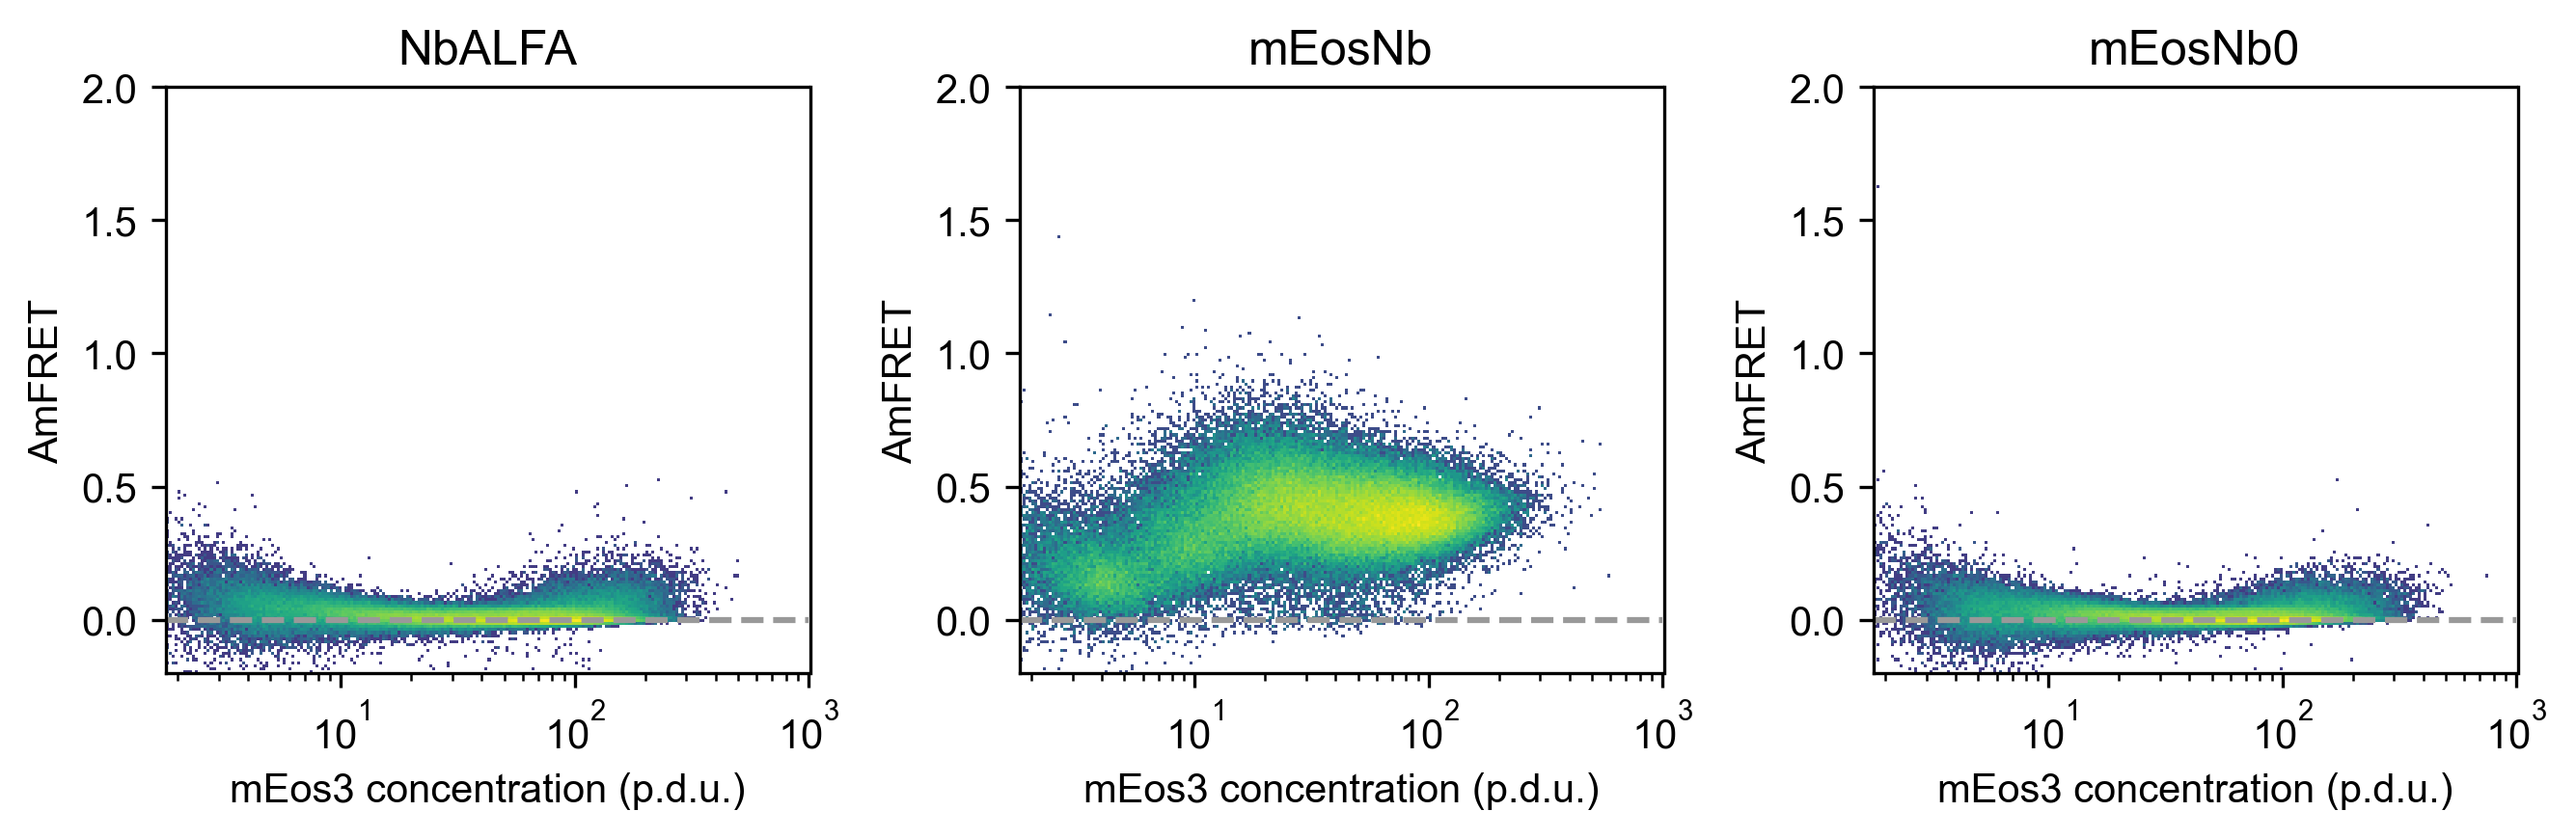

In [5]:
DAmFRETFig = plt.Figure((3*3 ,3), dpi=300)
DAmFRETAxs = DAmFRETFig.subplots(1,3, subplot_kw={'projection': "scatter_density"})
DAmFRETRow_files(NBTestFiles, DAmFRETAxs)
DAmFRETFig.tight_layout()
plt.show()
DAmFRETFig

In [6]:
# DAmFRETFig.savefig("plots/NBTest_DAmFRET.png")